# Árboles de decisión: Churn compañía de servicios de telefonía móvil

Vamos a aplicar un modelo de clasificación de árboles de decisión a un dataset que describe los clientes de una compañía que presta servicios de telefonía móvil que se han abandonado o no la compañía para irse a la competencia.

Importamos las librerías que vamos a utilizar

In [1]:
import numpy as np #operaciones matriciales y con vectores
import pandas as pd #tratamiento de datos
import matplotlib.pyplot as plt #gráficos
from sklearn import tree, datasets, metrics
#from sklearn import neighbors, datasets, metrics
from sklearn.model_selection import train_test_split #metodo de particionamiento de datasets para evaluación
from sklearn.model_selection import cross_val_score, cross_validate #método para evaluar varios particionamientos de C-V
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedKFold, LeaveOneOut #Iteradores de C-V
import seaborn as sns
import math

## Entendimiento de los datos

Cargamos los datos para entenderlos

In [2]:
data = pd.read_csv('02_churn.csv', sep=';', na_values=".")
print(data.shape)
data.head(5)

(20000, 12)


,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,LEAVE
0,zero,31953,0,6,313378,161,0,4,unsat,little,no,STAY
1,one,36147,0,13,800586,244,0,6,unsat,little,considering,STAY
2,one,27273,230,0,305049,201,16,15,unsat,very_little,perhaps,STAY
3,zero,120070,38,33,788235,780,3,2,unsat,very_high,considering,LEAVE
4,one,29215,208,85,224784,241,21,1,very_unsat,little,never_thought,STAY


**Parte 1**:
* Determine el número de registros, de variables, sus tipos ideales/reales, y sus rangos
* Determine el baseline y su accuracy. ¿Están balanceados los datos?
* ¿Encuentran algún problema con los datos (missing values, datos inválidos (sentido común --> Potes), )?
* Si fuésemos a utilizar K-NN, ¿debería hacerse algún pretratamiento de los datos?

El método **describe** permite obtener un dataframe con una descripción de las variables de un dataframe analizado. Para cada variable encontramos el número de registros validos (*count*).

Además, si se trata de una variable categórica, se puede obtener el número de clases posibles (*unique*), la clase mayoritaria (*top*) y la frecuencia de la clase mayoritaria (*freq*).

Y, si se trata de una variable numérica, se puede obtener el promedio (*mean*), desviación estándar (*std*), los valores mínimos (*min*) y máximos (*max*) y los cuartiles (*25%*, *50%* y *75%*).

In [3]:
data.describe(include="all")

,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,LEAVE
count,20000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000,20000,20000,20000
unique,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,5,5,2
top,one,NaN,NaN,NaN,NaN,NaN,NaN,NaN,very_unsat,little,considering,STAY
freq,10048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7909,7875,7920,10148
mean,NaN,80281.447750,85.979550,23.898650,493155.264250,389.615100,8.000700,6.002250,NaN,NaN,NaN,NaN
std,NaN,41680.586319,85.992324,26.816645,252407.884692,213.820682,8.925418,4.402558,NaN,NaN,NaN,NaN
min,NaN,20007.000000,-2.000000,0.000000,150002.000000,130.000000,0.000000,1.000000,NaN,NaN,NaN,NaN
25%,NaN,42217.000000,0.000000,0.000000,263714.250000,219.000000,1.000000,2.000000,NaN,NaN,NaN,NaN
50%,NaN,75366.500000,59.000000,14.000000,452259.500000,326.000000,4.000000,5.000000,NaN,NaN,NaN,NaN
75%,NaN,115881.750000,179.000000,41.000000,702378.000000,533.250000,15.000000,10.000000,NaN,NaN,NaN,NaN


In [4]:
data.LEAVE.describe()

count     20000
unique        2
top        STAY
freq      10148
Name: LEAVE, dtype: object

In [5]:
data.LEAVE.describe()['freq'] / data.LEAVE.describe()['count']

0.5074

Hay 12 atributos, incluyendo la variable objetivo LEAVE, que tiene cómo categoría mayoritaria STAY, que da un baseline de clasificación de 50,74%.

In [6]:
data.LEAVE.value_counts()

STAY     10148
LEAVE     9852
Name: LEAVE, dtype: int64

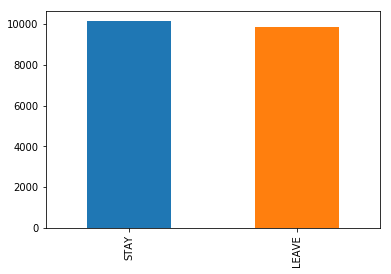

In [7]:
data.LEAVE.value_counts().plot.bar()

La variable objetivo está bastante balanceada

<font color='blue'>
    - Al parecer no hay problemas con datos faltantes (todas las variables tienen 20000 registros). <br/>
    - Las variables numéricas tienen escalas bastante diferentes, que resultarán en un problema al calcular distancias. <br/>
    - Los datos están bastante balanceados. <br/>
    - Hay un problema de incosistencia de datos con la variable OVERAGE, ya que su mínimo valor es de -2
</font>

**Parte 2**:

Utilizando pandas y matplotlib, analice la distribución de las variables independientes con respecto a los valores de la variable objetivo LEAVE y STAY. Trate de encontrar patrones en plots univariados (densidad) y Bivariados (scatterplots) para las variables numéricas, y gráficos de barras de conteo para las categóricas.